(-0.5, 511.5, 511.5, -0.5)

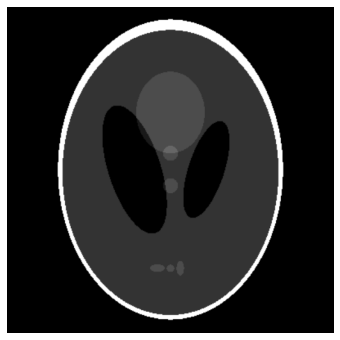

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import astra
import time

from torch_radon import Radon, RadonFanbeam
from torch_radon.solvers import cg
from torch_radon.shearlet import ShearletTransform


torch.set_grad_enabled(False)

def imshow(ax, img, title, colorbar=True, **kwargs):
    im = ax.imshow(img, **kwargs)
    if colorbar:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04).minorticks_on()
    ax.axis("off")
    ax.set_title(title)   

x = np.load("phantom.npy")
torch_x = torch.from_numpy(x).cuda()

plt.rcParams['figure.figsize'] = 6,6
plt.imshow(x, cmap="gray")
plt.axis("off")

0.8879614


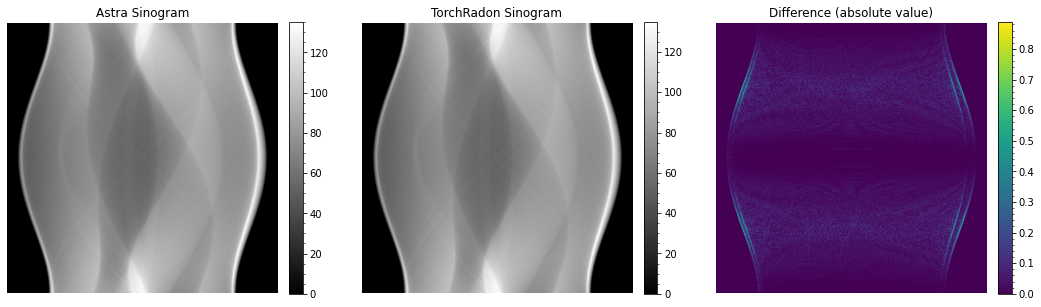

In [2]:
angles = np.linspace(0, np.pi, 512).astype(np.float32)

vol_geom = astra.create_vol_geom(x.shape[0], x.shape[1])
proj_geom = astra.create_proj_geom('parallel', 1.0, x.shape[0], angles)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

radon = Radon(x.shape[0], angles)

astra_sino_id, astra_sino = astra.create_sino(x, proj_id)
tr_sino_torch = radon.forward(torch_x)
tr_sino = tr_sino_torch.detach().cpu().numpy()

diff = np.abs(astra_sino - tr_sino)
print(np.max(diff))

plt.rcParams['figure.figsize'] = [18, 6]
fig, axs = plt.subplots(1, 3)
imshow(axs[0], astra_sino, "Astra Sinogram", cmap="gray")
imshow(axs[1], tr_sino, "TorchRadon Sinogram", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

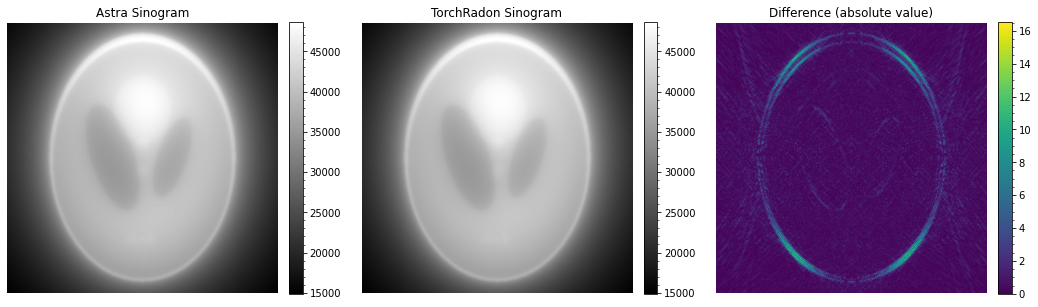

In [3]:
bp_id, bp = astra.create_backprojection(astra_sino, proj_id)
tr_bp = radon.backprojection(tr_sino_torch).detach().cpu().numpy()

diff = np.abs(bp - tr_bp)

fig, axs = plt.subplots(1, 3)
imshow(axs[0], bp, "Astra Sinogram", cmap="gray")
imshow(axs[1], tr_bp, "TorchRadon Sinogram", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

0.9847193


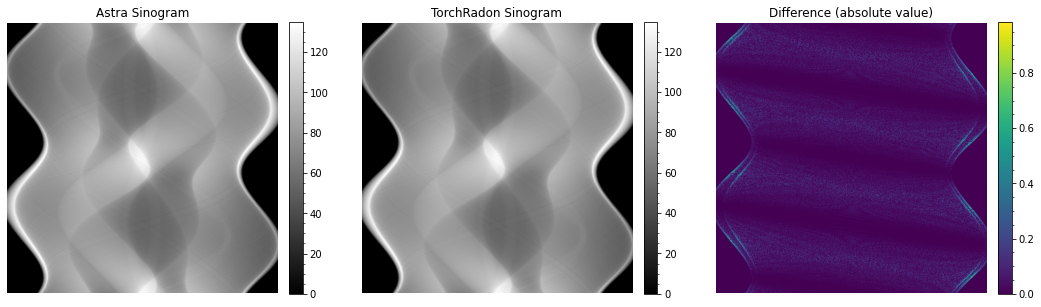

In [4]:
angles = np.linspace(0, 2*np.pi, 512).astype(np.float32)

s_dist = d_dist = x.shape[0]

vol_geom = astra.create_vol_geom(x.shape[0], x.shape[1])
proj_geom = astra.create_proj_geom('fanflat', 2.0, x.shape[0], angles, s_dist, d_dist)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)

radon = RadonFanbeam(x.shape[0], angles, s_dist, d_dist)

astra_sino_id, astra_sino = astra.create_sino(x, proj_id)
tr_sino_torch = radon.forward(torch_x)
tr_sino = tr_sino_torch.detach().cpu().numpy()

diff = np.abs(astra_sino - tr_sino)
print(np.max(diff))

fig, axs = plt.subplots(1, 3)
imshow(axs[0], astra_sino, "Astra Sinogram", cmap="gray")
imshow(axs[1], tr_sino, "TorchRadon Sinogram", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

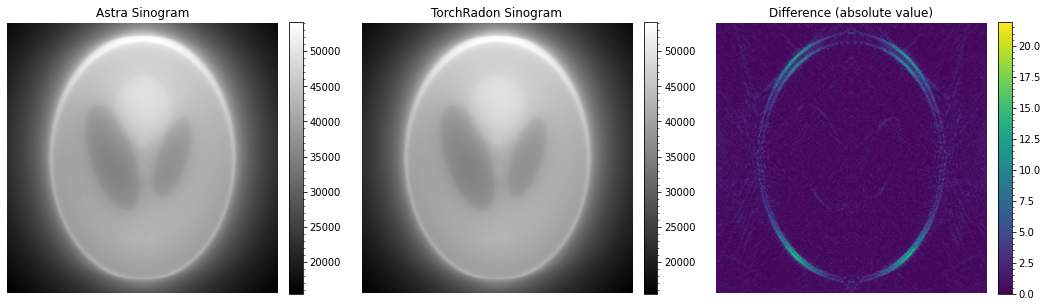

In [5]:
bp_id, bp = astra.create_backprojection(astra_sino, proj_id)
tr_bp = radon.backprojection(tr_sino_torch).detach().cpu().numpy()

diff = np.abs(bp - tr_bp)

fig, axs = plt.subplots(1, 3)
imshow(axs[0], bp, "Astra Sinogram", cmap="gray")
imshow(axs[1], tr_bp, "TorchRadon Sinogram", cmap="gray")
imshow(axs[2], diff, "Difference (absolute value)")

Astra MSE: 0.00020174522
Torch Radon MSE: 0.00022222748


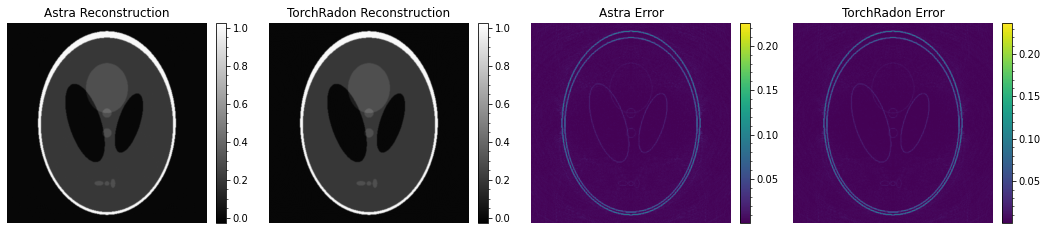

In [6]:
angles = np.linspace(0, np.pi, 512, endpoint=False).astype(np.float32)

det_count = int(np.ceil(np.sqrt(2)*x.shape[0]))

# Astra FBP
vol_geom = astra.create_vol_geom(x.shape[0], x.shape[1])
proj_geom = astra.create_proj_geom('parallel', 1.0, det_count, angles)
proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
astra_sino_id, astra_sino = astra.create_sino(x, proj_id)
vol_geom = astra.create_vol_geom(x.shape[0], x.shape[0])
rec_id = astra.data2d.create('-vol', vol_geom)
cfg = astra.astra_dict('FBP_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = astra_sino_id
cfg['option'] = {'FilterType': 'Ram-Lak'}
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id)
fbp = astra.data2d.get(rec_id)

# TorchRadon FBP
radon = Radon(x.shape[0], angles, det_count=det_count)
sinogram = radon.forward(torch_x)
filtered_sinogram = radon.filter_sinogram(sinogram)
fbp_tr = radon.backprojection(filtered_sinogram).detach().cpu().numpy()

diff = np.abs(x - fbp)
print("Astra MSE:", np.mean((x - fbp)**2))
print("Torch Radon MSE:", np.mean((x - fbp_tr)**2))


plt.rcParams['figure.figsize'] = [18, 6]
fig, axs = plt.subplots(1, 4)
imshow(axs[0], fbp, "Astra Reconstruction", cmap="gray")
imshow(axs[1], fbp_tr, "TorchRadon Reconstruction", cmap="gray")
imshow(axs[2], np.abs(x - fbp), "Astra Error")
imshow(axs[3], np.abs(x - fbp_tr), "TorchRadon Error")

# Half Precision

torch.Size([4, 512, 512])
MSE: 0.0003019103
FBP MSE: 0.00020566028
FBP HP MSE: 0.00020699103


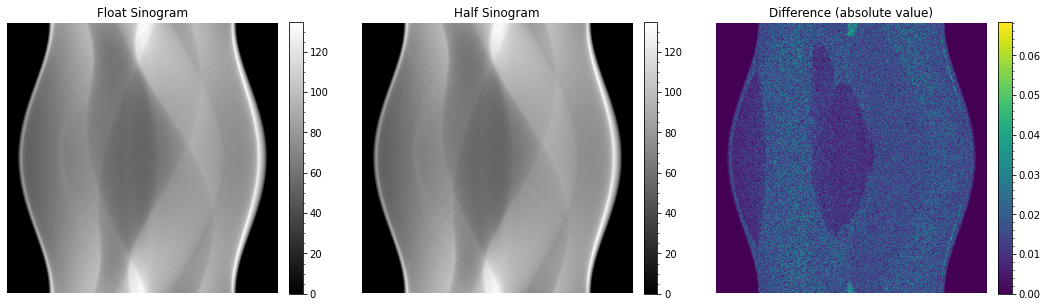

<Figure size 1296x432 with 0 Axes>

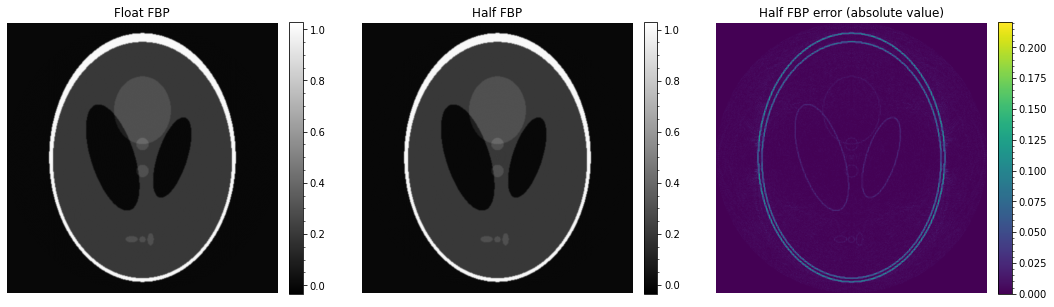

In [7]:
angles = np.linspace(0, np.pi, 512, endpoint=False).astype(np.float32)

batched_x = torch_x.view(1, x.shape[0], x.shape[1]).repeat(4, 1, 1)
print(batched_x.size())

radon = Radon(x.shape[0], angles, clip_to_circle=True)
sinogram = radon.forward(batched_x)
sinogram_hp = radon.forward(batched_x.half())

fbp = radon.backprojection(radon.filter_sinogram(sinogram))[0].cpu().detach().float().numpy()
fbp_hp = radon.backprojection(radon.filter_sinogram(sinogram_hp))[0].cpu().detach().float().numpy()

sino = sinogram[0].detach().cpu().numpy()
sino_hp = sinogram_hp[0].detach().cpu().float().numpy()

print("MSE:", np.mean((sino - sino_hp)**2))
print("FBP MSE:", np.mean((x - fbp)**2))
print("FBP HP MSE:", np.mean((x - fbp_hp)**2))


fig, axs = plt.subplots(1, 3)
imshow(axs[0], sino, "Float Sinogram", cmap="gray")
imshow(axs[1], sino_hp, "Half Sinogram", cmap="gray")
imshow(axs[2], np.abs(sino_hp - sino), "Difference (absolute value)")

plt.figure()
fig, axs = plt.subplots(1, 3)
imshow(axs[0], fbp, "Float FBP" , cmap="gray")
imshow(axs[1], fbp_hp, "Half FBP", cmap="gray")
imshow(axs[2], np.abs(x - fbp_hp), "Half FBP error (absolute value)")

# Learning the Invisible

Precomputing shearlet system: 100%|██████████| 58/58 [00:01<00:00, 32.95it/s]


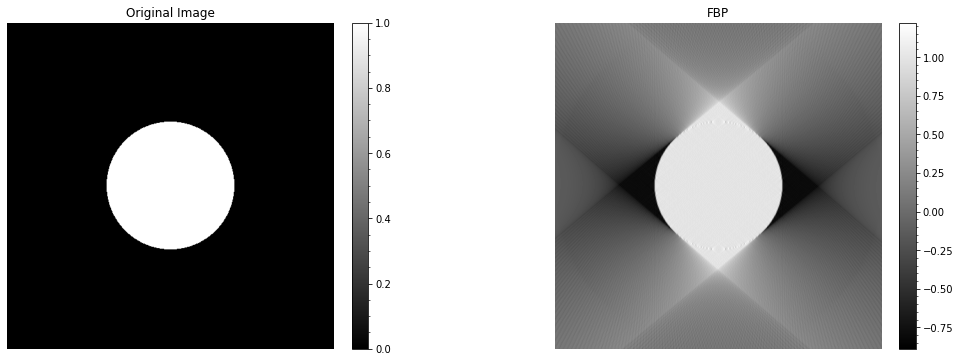

In [12]:
n_angles = 100
image_size = 512
circle_radius = 100
source_dist = 1.5*image_size
batch_size = 1
n_scales = 5

def circle_mask(size, radius):
    center = (size - 1) / 2
    c0, c1 = np.ogrid[0:size, 0:size]
    return ((c0 - center) ** 2 + (c1 - center) ** 2) <= radius ** 2

angles = (np.linspace(0., 100., n_angles, endpoint=False)-50.0) / 180.0 * np.pi

x = np.zeros((image_size, image_size), dtype=np.float32)
x[circle_mask(image_size, circle_radius)] = 1.0

radon = Radon(image_size, angles) #RadonFanbeam(image_size, angles, source_dist)
shearlet = ShearletTransform(image_size, image_size, [0.5] * n_scales)

torch_x = torch.from_numpy(x).cuda()
torch_x = torch_x.view(1, image_size, image_size).repeat(batch_size, 1, 1)
sinogram = radon.forward(torch_x)
fbp = radon.backward(radon.filter_sinogram(sinogram)).detach().cpu().numpy()

fig, axs = plt.subplots(1, 2)
imshow(axs[0], x, "Original Image", cmap="gray")
imshow(axs[1], fbp[0], "FBP", cmap="gray")
# imshow(axs[2], np.abs(sino_hp - sino), "Difference (absolute value)")


Running time: 6.576710224151611
Relative error:  9.247191995382309


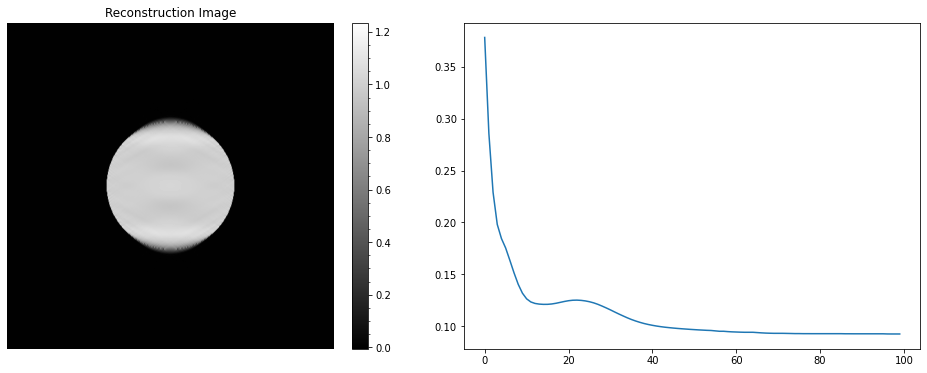

In [16]:
def shrink(a, b):
    return (torch.abs(a) - b).clamp_min(0) * torch.sign(a)


bp = radon.backward(sinogram)
sc = shearlet.forward(bp)

p_0 = 0.02
p_1 = 0.1
w = 3 ** shearlet.scales / 400
w = w.view(1, -1, 1, 1).cuda()

u_2 = torch.zeros_like(bp)
z_2 = torch.zeros_like(bp)
u_1 = torch.zeros_like(sc)
z_1 = torch.zeros_like(sc)
f = torch.zeros_like(bp)

relative_error = []
start_time = time.time()
for i in range(100):
    cg_y = p_0 * bp + p_1 * shearlet.backward(z_1 - u_1) + (z_2 - u_2)
    f = cg(lambda x: p_0 * radon.backward(radon.forward(x)) + (1 + p_1) * x, f.clone(), cg_y, max_iter=50)
    sh_f = shearlet.forward(f)

    # print(torch.norm(radon.forward(f) - sinogram).item() ** 2, torch.sum(torch.abs(sh_f)).item())

    z_1 = shrink(sh_f + u_1, p_0 / p_1 * w)
    z_2 = (f + u_2).clamp_min(0)
    u_1 = u_1 + sh_f - z_1
    u_2 = u_2 + f - z_2
    
    relative_error.append((torch.norm(torch_x[0] - f[0]) / torch.norm(torch_x[0])).item())
    
print("Running time:", time.time()-start_time)
print("Relative error: ", 100*relative_error[-1])


reconstruction = f[0].detach().cpu().numpy()
fig, axs = plt.subplots(1, 2)
imshow(axs[0], reconstruction, "Reconstruction Image", cmap="gray")
plt.plot(relative_error)